In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ======================= Data Loader =======================
def load_fives_data(data_path, img_size=(256, 256)):
    images = []
    masks = []
    labels = []

    for split in ['train', 'test']:
        split_path = os.path.join(data_path, split)
        orig_path = os.path.join(split_path, 'original')
        mask_path = os.path.join(split_path, 'ground truth')
        
        for filename in os.listdir(orig_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                label = filename.split('_')[-1][0]  # Extract label from filename
                if label not in ['D', 'G', 'N']:
                    continue
                
                # Load original image
                img = cv2.imread(os.path.join(orig_path, filename))
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                
                # Load corresponding mask
                mask = cv2.imread(os.path.join(mask_path, filename), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks) / 255.0    # Normalize masks
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension
    label_map = {'D': 0, 'G': 1, 'N': 2}
    labels = np.array([label_map[l] for l in labels])
    
    return images, masks, labels

# ======================= U-Net Model for Segmentation =======================
def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    # Output layer (Segmentation map)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = keras.Model(inputs, outputs)
    return model

# ======================= CNN Model for Disease Prediction =======================
def cnn_model(input_shape=(256, 256, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Three classes: D, G, N
    ])
    return model

# ======================= Training =======================
if __name__ == "__main__":
    data_path = r"C:\Users\rahul\Datascience notes\ATTEND\FIVES A Fundus Image Dataset for AI-based Vessel Segmentation"
    img_size = (256, 256)

    # Load dataset
    images, masks, labels = load_fives_data(data_path, img_size)
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(images, masks, test_size=0.2, random_state=42)

    # Train U-Net (Segmentation)
    unet = unet_model(input_shape=(256, 256, 3))
    unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    unet.fit(X_train_seg, y_train_seg, validation_data=(X_val_seg, y_val_seg), epochs=5, batch_size=16)
    unet.save("retinal_vessel_segmentation_unet.h5")

    # Train CNN (Disease Prediction)
    cnn = cnn_model(input_shape=(256, 256, 3))
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16)
    cnn.save("disease_prediction_cnn.h5")

    print("Training complete. Models saved.")

import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

# ======================= Prediction using Plot =======================
def predict_image(image_path):
    # Load models
    unet = keras.models.load_model("retinal_vessel_segmentation_unet.h5")
    cnn = keras.models.load_model("disease_prediction_cnn.h5")
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict segmentation
    vessel_mask = unet.predict(img)[0] 
    # Enhance contrast using CLAHE
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #vessel_mask = (vessel_mask * 255).astype(np.uint8)  # Convert to uint8
    #vessel_mask = clahe.apply(vessel_mask)

    
    # Predict disease
    disease_pred = cnn.predict(img)[0] >0.5
    classes = ['Diabetic', 'Glaucoma', 'Normal']
    predicted_disease = classes[np.argmax(disease_pred)]
    
    # Show the results
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axs[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original - {predicted_disease}")
    axs[0].axis('off')

    # Vessel Segmentation Mask
    axs[1].imshow(vessel_mask.squeeze(), cmap='gray')
    axs[1].set_title("Vessel Segmentation")
    axs[1].axis('off')
    
    plt.show()

    return vessel_mask, predicted_disease

# Example usage:
mask, disease = predict_image(r"C:\Users\rahul\Datascience notes\ATTEND\FIVES A Fundus Image Dataset for AI-based Vessel Segmentation\test\Original\150_G.png")
print(f"Predicted Disease: {disease}")


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [1]:
# ======================= Data Loader =======================
def load_fives_data(data_path, img_size=(256, 256)):
    images = []
    masks = []
    labels = []

    for split in ['train', 'test']:
        split_path = os.path.join(data_path, split)
        orig_path = os.path.join(split_path, 'original')
        mask_path = os.path.join(split_path, 'ground truth')
        
        for filename in os.listdir(orig_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                label = filename.split('_')[-1][0]  # Extract label from filename
                if label not in ['D', 'G', 'N']:
                    continue
                
                # Load original image
                img = cv2.imread(os.path.join(orig_path, filename))
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                
                # Load corresponding mask
                mask = cv2.imread(os.path.join(mask_path, filename), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images
    masks = np.array(masks) / 255.0    # Normalize masks
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension
    label_map = {'D': 0, 'G': 1, 'N': 2}
    labels = np.array([label_map[l] for l in labels])
    
    return images, masks, labels

In [2]:
# ======================= U-Net Model for Segmentation =======================
def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    # Output layer (Segmentation map)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = keras.Model(inputs, outputs)
    return model

In [3]:
# ======================= CNN Model for Disease Prediction =======================
def cnn_model(input_shape=(256, 256, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Three classes: D, G, N
    ])
    return model

In [4]:
# ======================= Training =======================
if __name__ == "__main__":
    data_path = r"C:\Users\rahul\Datascience notes\ATTEND\FIVES A Fundus Image Dataset for AI-based Vessel Segmentation"
    img_size = (256, 256)

    # Load dataset
    images, masks, labels = load_fives_data(data_path, img_size)
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(images, masks, test_size=0.2, random_state=42)

    # Train U-Net (Segmentation)
    unet = unet_model(input_shape=(256, 256, 3))
    unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    unet.fit(X_train_seg, y_train_seg, validation_data=(X_val_seg, y_val_seg), epochs=5, batch_size=16)
    unet.save("retinal_vessel_segmentation_unet.h5")

    # Train CNN (Disease Prediction)
    cnn = cnn_model(input_shape=(256, 256, 3))
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16)
    cnn.save("disease_prediction_cnn.h5")

    print("Training complete. Models saved.")


Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 827s 27s/step - accuracy: 0.8277 - loss: 0.4452 - val_accuracy: 0.9198 - val_loss: 0.2486
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 794s 26s/step - accuracy: 0.9219 - loss: 0.2369 - val_accuracy: 0.9198 - val_loss: 0.2403
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 997s 33s/step - accuracy: 0.9192 - loss: 0.2391 - val_accuracy: 0.9198 - val_loss: 0.2344
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 910s 30s/step - accuracy: 0.9199 - loss: 0.2306 - val_accuracy: 0.9198 - val_loss: 0.2221
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 910s 30s/step - accuracy: 0.9195 - loss: 0.2209 - val_accuracy: 0.9198 - val_loss: 0.2379


C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 666ms/step - accuracy: 0.3709 - loss: 4.4251 - val_accuracy: 0.6917 - val_loss: 0.7180
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.6828 - loss: 0.6706 - val_accuracy: 0.8250 - val_loss: 0.4351
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 606ms/step - accuracy: 0.8365 - loss: 0.3894 - val_accuracy: 0.8250 - val_loss: 0.4024
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 587ms/step - accuracy: 0.8415 - loss: 0.3663 - val_accuracy: 0.8417 - val_loss: 0.4243
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 589ms/step - accuracy: 0.8813 - loss: 0.2860 - val_accuracy: 0.8250 - val_loss: 0.3881


Training complete. Models saved.


In [2]:
# ======================= Prediction =======================
def predict_image(image_path):
    # Load models
    unet = keras.models.load_model("retinal_vessel_segmentation_unet.h5")
    cnn = keras.models.load_model("disease_prediction_cnn.h5")
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict segmentation
    vessel_mask = unet.predict(img)[0]

    # Predict disease
    disease_pred = cnn.predict(img)[0]
    classes = ['Diabetic', 'Glaucoma', 'Normal']
    predicted_disease = classes[np.argmax(disease_pred)]
    
    return vessel_mask, predicted_disease

# Example usage:
mask, disease = predict_image(r"C:\Users\rahul\Datascience notes\ATTEND\image_18.jpg")
print(f"Predicted Disease: {disease}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Predicted Disease: Normal


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


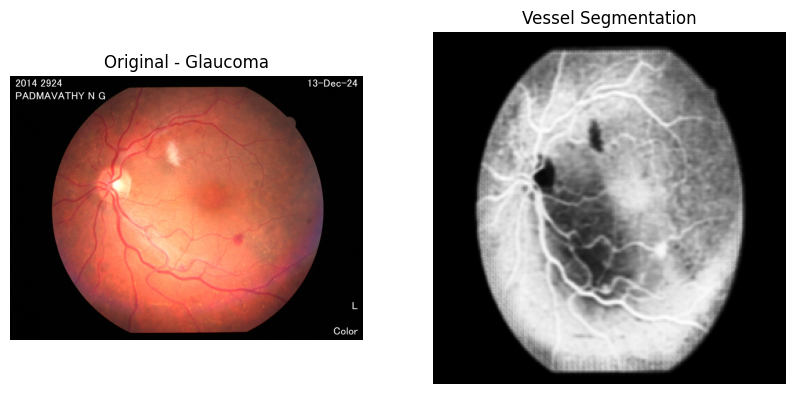

Predicted Disease: Glaucoma


In [5]:
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

# ======================= Prediction using Plot =======================
def predict_image(image_path):
    # Load models
    unet = keras.models.load_model("retinal_vessel_segmentation_unet.h5")
    cnn = keras.models.load_model("disease_prediction_cnn.h5")
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict segmentation
    vessel_mask = unet.predict(img)[0] 
    # Enhance contrast using CLAHE
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #vessel_mask = (vessel_mask * 255).astype(np.uint8)  # Convert to uint8
    #vessel_mask = clahe.apply(vessel_mask)

    
    # Predict disease
    disease_pred = cnn.predict(img)[0] >0.5
    classes = ['Diabetic', 'Glaucoma', 'Normal']
    predicted_disease = classes[np.argmax(disease_pred)]
    
    # Show the results
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axs[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original - {predicted_disease}")
    axs[0].axis('off')

    # Vessel Segmentation Mask
    axs[1].imshow(vessel_mask.squeeze(), cmap='gray')
    axs[1].set_title("Vessel Segmentation")
    axs[1].axis('off')
    
    plt.show()

    return vessel_mask, predicted_disease

# Example usage:
mask, disease = predict_image(r"C:\Users\rahul\Downloads\2014 2924_20241213163940600.jpg")
print(f"Predicted Disease: {disease}")
